In [52]:
#импорт библиотек и методов анализа
import numpy as np #линейная алгебрра
import pandas as pd #обработка данных, загрузка, сохранение
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.decomposition import PCA

plt.style.use('ggplot')


### ЗАГРУЗКА И ПРЕДВАРИТЕЛЬНЫЙ ПРОСМОТР ДАННЫХ

In [4]:
# загрузка данных из .csv файла в переменную data
data = pd.read_csv('input/column_2C_weka.csv')

Посмотреть на загруженные данные

In [5]:
data.head(10) #первые 10 образцов

pelvic_incidence  pelvic_tilt numeric  lumbar_lordosis_angle  sacral_slope  \
0         63.027818            22.552586              39.609117     40.475232   
1         39.056951            10.060991              25.015378     28.995960   
2         68.832021            22.218482              50.092194     46.613539   
3         69.297008            24.652878              44.311238     44.644130   
4         49.712859             9.652075              28.317406     40.060784   
5         40.250200            13.921907              25.124950     26.328293   
6         53.432928            15.864336              37.165934     37.568592   
7         45.366754            10.755611              29.038349     34.611142   
8         43.790190            13.533753              42.690814     30.256437   
9         36.686353             5.010884              41.948751     31.675469   

   pelvic_radius  degree_spondylolisthesis     class  
0      98.672917                 -0.254400  Abnormal  
1     114.405425                  4.564259  Abnormal  
2     105.985135                 -3.530317  Abnormal  
3     101.868495                 11.211523  Abnormal  
4     108.168725                  7.918501  Abnormal  
5     130.327871                  2.230652  Abnormal  
6     120.567523                  5.988551  Abnormal  
7     117.270068                -10.675871  Abnormal  
8     125.002893                 13.289018  Abnormal  
9      84.241415                  0.664437  Abnormal

In [6]:
# вывести информацию о данных - сколько всего измерений, есть ли пропуски и т.д.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
pelvic_incidence            310 non-null float64
pelvic_tilt numeric         310 non-null float64
lumbar_lordosis_angle       310 non-null float64
sacral_slope                310 non-null float64
pelvic_radius               310 non-null float64
degree_spondylolisthesis    310 non-null float64
class                       310 non-null object
dtypes: float64(6), object(1)
memory usage: 17.0+ KB


In [7]:
# вывести статистические характеристики данных
data.describe()

pelvic_incidence  pelvic_tilt numeric  lumbar_lordosis_angle  \
count        310.000000           310.000000             310.000000   
mean          60.496653            17.542822              51.930930   
std           17.236520            10.008330              18.554064   
min           26.147921            -6.554948              14.000000   
25%           46.430294            10.667069              37.000000   
50%           58.691038            16.357689              49.562398   
75%           72.877696            22.120395              63.000000   
max          129.834041            49.431864             125.742385   

       sacral_slope  pelvic_radius  degree_spondylolisthesis  
count    310.000000     310.000000                310.000000  
mean      42.953831     117.920655                 26.296694  
std       13.423102      13.317377                 37.559027  
min       13.366931      70.082575                -11.058179  
25%       33.347122     110.709196                  1.603727  
50%       42.404912     118.268178                 11.767934  
75%       52.695888     125.467674                 41.287352  
max      121.429566     163.071041                418.543082

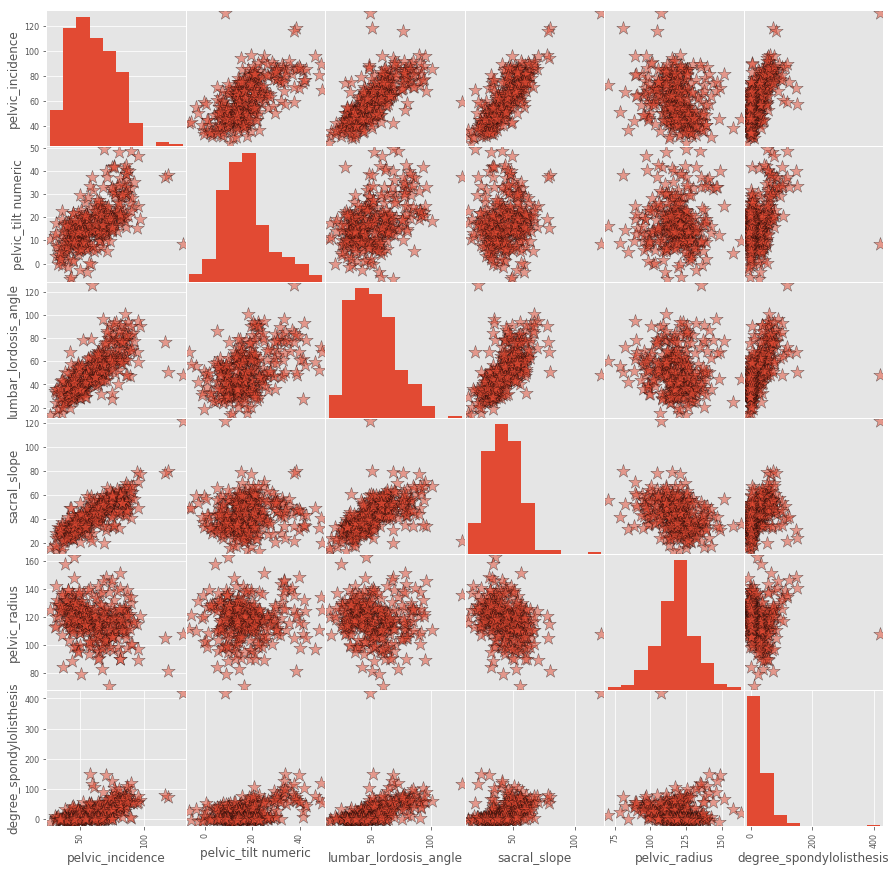

In [9]:
# визуализация признаков с помощью графиков для разных классов в колонке class в исходных данных
#color_list = ['red' if i==1 elif i==2 'green' elif i==3 'yellow' for i in data.loc[:,'class']]
color_list = ['red', 'green', 'yellow', 'cyan', 'magenta','blue','black']
pd.plotting.scatter_matrix(data.loc[:, data.columns != 'class'],
                                      # c=color_list,
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 200,
                                       marker = '*',
                                       edgecolor= "black")
plt.show()

### ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ

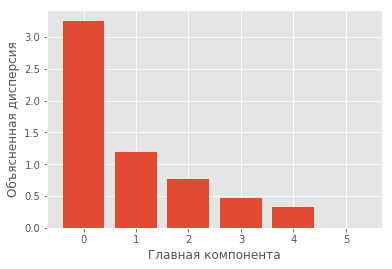

In [11]:
# Масштабирование данных и метод главных компонент
data_x = data.drop('class',axis = 1) #выбросим из данных зависимую переменную 'class'
scaler = StandardScaler() # стандартная операция масштабирования
pca = PCA() #метод главных компонент (МГК)
preproc_pipeline = make_pipeline(scaler,pca) # создадим конвейер из масштабирования МГК
preproc_pipeline.fit(data_x) # запустим конвейер на данных (независмых переменных)

#построим график с результатами, на основе которых выберем число главных компонент
plt.bar(range(pca.n_components_), pca.explained_variance_)
plt.xlabel('Главная компонента')
plt.ylabel('Объясненная дисперсия')
plt.show()

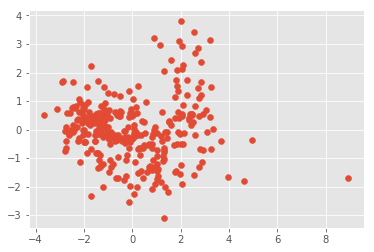

In [23]:
# Применим МГК к исходным данным с выбранным числом главных компонент
pca = PCA(n_components = 3)
preproc_pipeline = make_pipeline(scaler,pca)
preproc_pipeline.fit(data_x)
data_x_pca = preproc_pipeline.transform(data_x)

#построим график наших данных в координатах первых двух ГК
x_1 = data_x_pca[:,0]
x_2 = data_x_pca[:,1]
plt.scatter(x_1, x_2)
plt.show()

#также сделаем вариант с только отмасштабированными данными, без МГК
scaler = StandardScaler()
scaler.fit(data_x)
data_x_scaled =  scaler.transform(data_x)


## ПОСТРОЕНИЕ МОДЕЛИ

Классификация

Подобранные параметры модели: {'n_neighbors': 35}
Наилучшая точность при перекрестной проверке модели: 0.842741935483871
Точность на тестовом наборе: 0.7903225806451613
Матрица ошибок: 
 [[36  6]
 [ 7 13]]
Отчет по модели классификации: 
               precision    recall  f1-score   support

    Abnormal       0.84      0.86      0.85        42
      Normal       0.68      0.65      0.67        20

   micro avg       0.79      0.79      0.79        62
   macro avg       0.76      0.75      0.76        62
weighted avg       0.79      0.79      0.79        62



/home/vs/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


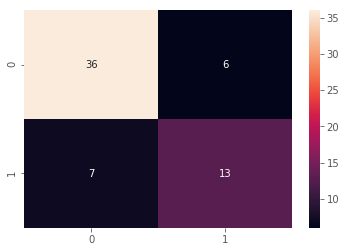

In [26]:
# y - столбец class, x - предобработанные данные (например, с масштабированием)
x = data_x_scaled
y = data.loc[:,'class']

#создадим модель
model = KNeighborsClassifier()

# выполним перебор параметров модели по сетке
parameters = {'n_neighbors': np.arange(2,50)} #сетка параметров
cv = GridSearchCV(model, param_grid=parameters, cv=3) #перебор с перекрестной проверкой с кратностью 3

# сделаем также тестовый и обучающие наборы для тестирования обученной модели
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state = 1)

cv.fit(x_train,y_train) #обучение на обучающем наборе
y_pred = cv.predict(x_test) #проверка на тестирующем наборе


print("Подобранные параметры модели: {}".format(cv.best_params_))
print("Наилучшая точность при перекрестной проверке модели: {}".format(cv.best_score_))
print("Точность на тестовом наборе: {}".format(cv.score(x_test, y_test)))

# матрица ошибок классификации
cm = confusion_matrix(y_test,y_pred)
print('Матрица ошибок: \n',cm)
print('Отчет по модели классификации: \n',classification_report(y_test,y_pred))
# Визуализация матрицы
sns.heatmap(cm,annot=True,fmt="d") 
plt.show()

Регрессия

R^2:  0.3580668710533108


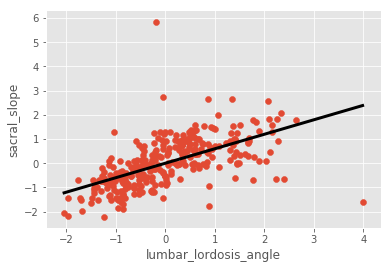

In [29]:
# после масштабирования данных, мы уже не можем обращаться по имени столбцов
# поэтому используем просто их номера
x_regr = np.array(data_x_scaled[:,2]).reshape(-1,1) 
y_regr = np.array(data_x_scaled[:,3]).reshape(-1,1)

# модель линейной регрессии

reg = LinearRegression()
predict_space = np.linspace(min(x_regr), max(x_regr)).reshape(-1,1)
reg.fit(x_regr, y_regr)

predicted = reg.predict(predict_space)
print('R^2: ',reg.score(x_regr, y_regr))
plt.plot(predict_space, predicted, color='black', linewidth=3)
plt.scatter(x=x_regr,y=y_regr)
plt.xlabel('lumbar_lordosis_angle')
plt.ylabel('sacral_slope')
plt.show()


In [47]:
# Более сложная модель регрессии - SVR - Support Vector Regression
x_regr = np.array(data_x_scaled[:,2]).reshape(-1,1) 
y_regr = np.array(data_x_scaled[:,3])

#создадим модель
model = SVR()

# выполним перебор параметров модели по сетке
parameters = {'C'    :[1, 2, 5, 10],
              'gamma':[0.1, 0.01, 0.001, 0.0001]} #сетка параметров

# Зададим способ оценки модели по параметру neg_mean_squared_error - средняя квадратическая ошибка
# Также модель можно оценивать и по другим критериям - neg_mean_absolute_error, r2, mutual_info_score,...
# Смотри в документации 3.3.4.Regression metrics https://scikit-learn.org/stable/modules/model_evaluation.htm
model_scoring = 'neg_mean_squared_error'

#перебор с перекрестной проверкой
cv = GridSearchCV(model, param_grid=parameters, cv=4, scoring=model_scoring) 

# сделаем также тестовый и обучающие наборы для тестирования обученной модели
x_train, x_test, y_train, y_test = train_test_split(x_regr, y_regr, test_size=0.2, random_state = 1)

cv.fit(x_train,y_train)     # обучение на обучающем наборе
y_pred = cv.predict(x_test) # проверка на тестирующем наборе

# получим оценку модели на тестовом наборе
scores = cross_val_score(cv, x_test, y_test, cv=4, scoring=model_scoring)

print("Подобранные параметры модели: {}".format(cv.best_params_))
print("Наилучшее значение {} при перекрестной проверке модели: {}".format(model_scoring, cv.best_score_))
print("{} на тестовом наборе: {}".format(model_scoring, scores))
print("Среднее {} на тестовом наборе: {}".format(model_scoring, scores.mean()))




/home/vs/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Подобранные параметры модели: {'C': 1, 'gamma': 0.1}
Наилучшее значение neg_mean_squared_error при перекрестной проверке модели: -0.5842168622688555
neg_mean_squared_error на тестовом наборе: [-0.29854248 -0.57509435 -0.31003879 -1.05071354]
Среднее neg_mean_squared_error на тестовом наборе: -0.5585972903377064


/home/vs/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [56]:
# `outer_cv` - внешняя 3-х кратная перекрестная проверка для оценки модели
outer_cv = KFold(3)

# при обучении на одной из частей, выбранных при внешней перекрестоной проверке
# используем ещё одну, внутреннюю 3-х кратную перекрестную проверку для выбора параметров алгоритма
inner_cv = KFold(3)

# будем рассмтаривать два алгоритма - SVR и Random Forest
# создадим модели и сетки для подбора параметров
models_and_parameters = {
    'svr': (SVR(gamma='scale'),
            {'C': [0.01, 0.05, 0.1, 1]}),
    'rf': (RandomForestRegressor(),
           {'max_depth': [5, 10, 50, 100, 200, 500]})}

# будем сохранять средние значения для внешней перекрестной проверки
avg_scores_per_model = dict()

# в цикле ищем модель с наилучшей оценкой
for name, (model, params) in models_and_parameters.items():
    # перебор по сетке, внутренняя перекрестная проверка
    model_cv = GridSearchCV(estimator=model, param_grid=params,cv=inner_cv, scoring='neg_mean_squared_error')

    # оценка модели, внешняя перекрестная проверка
    scores = cross_val_score(model_cv, x_regr, y_regr, cv=outer_cv, scoring='neg_mean_squared_error')

    # среднее значение MSE
    avg_scores_per_model[name] = np.mean(scores)
    error_summary = 'Модель: {}\nMSE перекрестной проверки: {}.\nСреднее MSE: {}'.format(name,
                                                                                         scores,
                                                                                         np.mean(scores))

    
print('Средняя ошибка по внешней перекрестной проверке: ', avg_scores_per_model)

break_line = '\n' + '*' * 50 + '\n'
print(break_line + 'Выбор наилучшей модели и её обучение' + break_line)

best_model_name, best_model_avg_score = max(
    avg_scores_per_model.items(),
    key=(lambda name_averagescore: name_averagescore[1]))

# получим наилучшую модель и её сетку параметров
best_model, best_model_params = models_and_parameters[best_model_name]

# обучим эту модель на всем наборе данных, после чего модель может использоваться на новых данных
final_model = GridSearchCV(best_model, best_model_params, cv=inner_cv)
final_model.fit(x_regr, y_regr)

print('Лучшая модель: \n\t{}'.format(best_model), end='\n\n')
print('Оценка модели (negative mean squared error):\n\t{}'.format(best_model_avg_score), end='\n\n')
print('Наилучшие параметры для этой модели: \n\t', final_model.best_params_)

/home/vs/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/

/home/vs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:2

Средняя ошибка по внешней перекрестной проверке:  {'svr': -0.6336471073880892, 'rf': -0.7257990597066044}

**************************************************
Выбор наилучшей модели и её обучение
**************************************************

Лучшая модель: 
	SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Оценка модели (negative mean squared error):
	-0.6336471073880892

Наилучшие параметры для этой модели: 
	 {'C': 1}


/home/vs/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
